## Installing Required Libraries

## Importing required Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import re
from typing import List, Dict, Any, Tuple
from sentence_transformers import SentenceTransformer
from openai import OpenAI
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from dotenv import load_dotenv
import openai
import os
from langchain_community.utilities import GoogleSerperAPIWrapper



# ✅ Load environment variables
load_dotenv()
openai_api_key = os.getenv("OPEN_AI_KEY")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")



/Users/vijendra/multi-agent-system/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

ds = load_dataset("deccan-ai/insuranceQA-v2")



### Setting up the FAQ Data

In [3]:
from datasets import load_dataset
import pandas as pd

# Load the dataset from Hugging Face
ds = load_dataset("deccan-ai/insuranceQA-v2")

# Combine all splits into a single DataFrame
df = pd.concat([split.to_pandas() for split in ds.values()], ignore_index=True)
df["combined"] = "Question: " + df["input"] + " \n Answer:  " + df["output"]
# Inspect
df.head()


,input,output,combined
0,What Does Medicare IME Stand For?,According to the Centers for Medicare and Medi...,Question: What Does Medicare IME Stand For? \...
1,Is Long Term Care Insurance Tax Free?,"As a rule , if you buy a tax qualified long te...",Question: Is Long Term Care Insurance Tax Free...
2,Can Husband Drop Wife From Health Insurance?,Can a spouse drop another spouse from health i...,Question: Can Husband Drop Wife From Health In...
3,Is Medicare Run By The Government?,Medicare Part A and Part B is provided by the ...,Question: Is Medicare Run By The Government? ...
4,Is Medicare Run By The Government?,Definitely . It is ran by the Center for Medic...,Question: Is Medicare Run By The Government? ...


In [4]:
import chromadb
# Setting up the Chromadb
client = chromadb.PersistentClient(path="./chroma_db")

In [6]:
# Collection 1 for insurance Q&A Dataset
from tqdm import tqdm
df = df.sample(200, random_state=42).reset_index(drop=True)  # For testing, use a smaller subset
collection = client.get_or_create_collection(name="insurance_FAQ_collection")
# Add data to collection
# here the chroma db will use default embeddings (sentence transformers)
# Split into batches of <= 5000
batch_size = 100

for i in tqdm(range(0, len(df), batch_size)):
    batch_df = df.iloc[i:i+batch_size]
    collection.add(
        documents=batch_df["combined"].tolist(),
        metadatas=[{"question": q, "answer": a} for q, a in zip(batch_df["input"], batch_df["output"])],
        ids=batch_df.index.astype(str).tolist()
    )




100%|██████████| 2/2 [00:06<00:00,  3.01s/it]


In [8]:
results

{'ids': [['18546', '18549', '1283']],
 'embeddings': None,
 'documents': [['Question: What Does Life Insurance Typically Cover?  \n Answer:  Life insurance is intended to provide some monetary assistance in the event that the insured passes away while covered . Life insurance is typically meant as a way for the family of the insured to be financially capable of moving on after the loss . The funds from the policy are intended to help provide for those things that could have possibly been provided -LRB- i.e. pay off debt , pay for college , etc. . . -RRB- by the insured if the insured had not passed . This is a very limited explanation of life insurance , contact a local agent to discuss your wants and needs with this type of coverage . ',
   'Question: What Does Life Insurance Typically Cover?  \n Answer:  Life insurance is designed to pay a determined benefit amount upon the death of the insured . Any cause of death is typically covered except suicide within the first two years of the

In [7]:
## Testing the retrieval
query = "What does life insurance cover?"
collection = client.get_collection(name="insurance_FAQ_collection")
results = collection.query(
    query_texts=[query],
    n_results=3,
    include=["metadatas", "documents"]
)

for i, m in enumerate(results["metadatas"][0]):
    print(f"Result {i+1}:")
    #print("Score:", results["distances"][0][i])
    print("Q:", m["question"])
    print("A:", m["answer"])
    print("-" * 50)


Result 1:
Q: What Does Life Insurance Typically Cover? 
A: Life insurance is intended to provide some monetary assistance in the event that the insured passes away while covered . Life insurance is typically meant as a way for the family of the insured to be financially capable of moving on after the loss . The funds from the policy are intended to help provide for those things that could have possibly been provided -LRB- i.e. pay off debt , pay for college , etc. . . -RRB- by the insured if the insured had not passed . This is a very limited explanation of life insurance , contact a local agent to discuss your wants and needs with this type of coverage . 
--------------------------------------------------
Result 2:
Q: What Does Life Insurance Typically Cover? 
A: Life insurance is designed to pay a determined benefit amount upon the death of the insured . Any cause of death is typically covered except suicide within the first two years of the policy . If it can be proved that fraud wa

## Generating Synthetic Data

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

def generate_sample_data():
    """Generate enriched sample data for all tables with 50 first/last names"""
    # Define 50 first and last names
    first_names = [
        "John", "Jane", "Robert", "Maria", "David", "Lisa", "Michael", "Sarah", "James", "Emily",
        "William", "Emma", "Joseph", "Olivia", "Charles", "Ava", "Thomas", "Isabella", "Daniel", "Mia",
        "Matthew", "Sophia", "Anthony", "Charlotte", "Christopher", "Amelia", "Andrew", "Harper",
        "Joshua", "Evelyn", "Ryan", "Abigail", "Brandon", "Ella", "Justin", "Scarlett", "Tyler", "Grace",
        "Alexander", "Chloe", "Kevin", "Victoria", "Jason", "Lily", "Brian", "Hannah", "Eric", "Aria",
        "Kyle", "Zoey"
    ]

    last_names = [
        "Smith", "Johnson", "Williams", "Brown", "Jones", "Garcia", "Miller", "Davis", "Rodriguez", "Martinez",
        "Hernandez", "Lopez", "Gonzalez", "Wilson", "Anderson", "Thomas", "Taylor", "Moore", "Jackson", "Martin",
        "Lee", "Perez", "Thompson", "White", "Harris", "Sanchez", "Clark", "Ramirez", "Lewis", "Robinson",
        "Walker", "Young", "Allen", "King", "Wright", "Scott", "Torres", "Nguyen", "Hill", "Flores",
        "Green", "Adams", "Nelson", "Baker", "Hall", "Rivera", "Campbell", "Mitchell", "Carter", "Roberts"
    ]

    # Generate customers (1000 random name combinations)
    customers = pd.DataFrame({
        'customer_id': [f'CUST{str(i).zfill(5)}' for i in range(1, 1001)],
        'first_name': [random.choice(first_names) for _ in range(1000)],
        'last_name': [random.choice(last_names) for _ in range(1000)],
        'email': [f'user{i}@example.com' for i in range(1, 1001)],
        'phone': [f'555-{str(random.randint(100,999)).zfill(3)}-{str(random.randint(1000,9999)).zfill(4)}' for _ in range(1000)],
        'date_of_birth': [datetime(1980, 1, 1) + timedelta(days=random.randint(0, 10000)) for _ in range(1000)],
        'state': [random.choice(['CA', 'NY', 'TX', 'FL', 'IL', 'PA', 'OH', 'GA']) for _ in range(1000)]
    })

    # Policies
    policies = pd.DataFrame({
        'policy_number': [f'POL{str(i).zfill(6)}' for i in range(1, 1501)],
        'customer_id': [f'CUST{str(random.randint(1, 1000)).zfill(5)}' for _ in range(1500)],
        'policy_type': [random.choice(['auto', 'home', 'life']) for _ in range(1500)],
        'start_date': [datetime(2023, 1, 1) + timedelta(days=random.randint(0, 365)) for _ in range(1500)],
        'premium_amount': [round(random.uniform(50, 500), 2) for _ in range(1500)],
        'billing_frequency': [random.choice(['monthly', 'quarterly', 'annual']) for _ in range(1500)],
        'status': [random.choice(['active', 'active', 'active', 'cancelled']) for _ in range(1500)]
    })

    # Auto Policy Details (subset)
    auto_policies = policies[policies['policy_type'] == 'auto'].copy()
    auto_policy_details = pd.DataFrame({
        'policy_number': auto_policies['policy_number'],
        'vehicle_vin': [f'VIN{random.randint(10000000000000000, 99999999999999999)}' for _ in range(len(auto_policies))],
        'vehicle_make': [random.choice(['Toyota', 'Honda', 'Ford', 'Chevrolet', 'Nissan']) for _ in range(len(auto_policies))],
        'vehicle_model': [random.choice(['Camry', 'Civic', 'F-150', 'Malibu', 'Altima']) for _ in range(len(auto_policies))],
        'vehicle_year': [random.randint(2015, 2023) for _ in range(len(auto_policies))],
        'liability_limit': [random.choice([50000, 100000, 300000]) for _ in range(len(auto_policies))],
        'collision_deductible': [random.choice([250, 500, 1000]) for _ in range(len(auto_policies))],
        'comprehensive_deductible': [random.choice([250, 500, 1000]) for _ in range(len(auto_policies))],
        'uninsured_motorist': [random.choice([0, 1]) for _ in range(len(auto_policies))],
        'rental_car_coverage': [random.choice([0, 1]) for _ in range(len(auto_policies))]
    })

    # Payment Methods
    payment_methods = pd.DataFrame({
        'method_id': [f'PM{str(i).zfill(6)}' for i in range(1, 1501)],
        'customer_id': [f'CUST{str(random.randint(1, 1000)).zfill(5)}' for _ in range(1500)],
        'payment_type': [random.choice(['credit_card', 'debit_card', 'bank_account']) for _ in range(1500)],
        'last_four_digits': [f'{random.randint(1000,9999)}' for _ in range(1500)],
        'expiry_date': [f'202{random.randint(5,8)}-{random.randint(1,12):02d}-{random.randint(1,28):02d}' for _ in range(1500)],
        'is_default': [random.choice([0, 1]) for _ in range(1500)]
    })

    # Billing
    billing = pd.DataFrame({
        'bill_id': [f'BILL{str(i).zfill(6)}' for i in range(1, 5001)],
        'policy_number': [random.choice(policies['policy_number']) for _ in range(5000)],
        'billing_date': [datetime(2024, 1, 1) + timedelta(days=random.randint(0, 90)) for _ in range(5000)],
        'due_date': [datetime(2024, 1, 15) + timedelta(days=random.randint(0, 90)) for _ in range(5000)],
        'amount_due': [round(random.uniform(100, 1000), 2) for _ in range(5000)],
        'status': [random.choice(['paid', 'pending', 'overdue']) for _ in range(5000)]
    })

    # Payments
    payments = pd.DataFrame({
        'payment_id': [f'PAY{str(i).zfill(6)}' for i in range(1, 4001)],
        'bill_id': [random.choice(billing['bill_id']) for _ in range(4000)],
        'payment_date': [datetime(2024, 1, 1) + timedelta(days=random.randint(0, 90)) for _ in range(4000)],
        'amount': [round(random.uniform(50, 500), 2) for _ in range(4000)],
        'payment_method': [random.choice(['credit_card', 'debit_card', 'bank_transfer']) for _ in range(4000)],
        'transaction_id': [f'TXN{random.randint(100000,999999)}' for _ in range(4000)],
        'status': [random.choice(['completed', 'pending', 'failed']) for _ in range(4000)]
    })

    # Claims
    claims = pd.DataFrame({
        'claim_id': [f'CLM{str(i).zfill(6)}' for i in range(1, 301)],
        'policy_number': [random.choice(policies['policy_number']) for _ in range(300)],
        'claim_date': [datetime(2024, 1, 1) + timedelta(days=random.randint(0, 90)) for _ in range(300)],
        'incident_type': [random.choice(['collision', 'theft', 'property_damage', 'medical', 'liability']) for _ in range(300)],
        'estimated_loss': [round(random.uniform(500, 20000), 2) for _ in range(300)],
        'status': [random.choice(['submitted', 'under_review', 'approved', 'paid', 'denied']) for _ in range(300)]
    })

    # Claim Documents
    claim_documents = pd.DataFrame({
        'document_id': [f'DOC{str(i).zfill(6)}' for i in range(1, 601)],
        'claim_id': [random.choice(claims['claim_id']) for _ in range(600)],
        'document_type': [random.choice(['photo', 'police_report', 'estimate', 'invoice']) for _ in range(600)],
        'document_url': [f'https://example.com/documents/{i}.pdf' for i in range(1, 601)],
        'uploaded_date': [datetime.now() - timedelta(days=random.randint(0, 60)) for _ in range(600)]
    })

    return {
        'customers': customers,
        'policies': policies,
        'auto_policy_details': auto_policy_details,
        'payment_methods': payment_methods,
        'billing': billing,
        'payments': payments,
        'claims': claims,
        'claim_documents': claim_documents
    }


sample_data = generate_sample_data()

In [10]:
print("Custimers Data Shape:", sample_data["customers"].shape)
sample_data["customers"].head()

Custimers Data Shape: (1000, 7)


,customer_id,first_name,last_name,email,phone,date_of_birth,state
0,CUST00001,Christopher,Ramirez,user1@example.com,555-197-4851,1990-06-13,OH
1,CUST00002,Amelia,Thomas,user2@example.com,555-909-6882,1996-06-06,IL
2,CUST00003,Kevin,Jones,user3@example.com,555-472-9099,2006-06-28,IL
3,CUST00004,Scarlett,Robinson,user4@example.com,555-848-5031,2003-04-15,IL
4,CUST00005,James,Flores,user5@example.com,555-879-2450,2002-06-29,GA


In [11]:
print("billing Data Shape:", sample_data["billing"].shape)
sample_data["billing"].head()

billing Data Shape: (5000, 6)


,bill_id,policy_number,billing_date,due_date,amount_due,status
0,BILL000001,POL000610,2024-02-13,2024-03-31,947.85,pending
1,BILL000002,POL000334,2024-02-23,2024-02-25,203.10,paid
2,BILL000003,POL000010,2024-02-01,2024-03-25,652.12,pending
3,BILL000004,POL001122,2024-01-04,2024-01-19,858.38,pending
4,BILL000005,POL001227,2024-02-28,2024-03-05,593.06,overdue


In [12]:
print("claims Data Shape:", sample_data["claims"].shape)
sample_data["claims"].head()

claims Data Shape: (300, 6)


,claim_id,policy_number,claim_date,incident_type,estimated_loss,status
0,CLM000001,POL001200,2024-02-26,collision,19442.86,paid
1,CLM000002,POL001293,2024-02-28,theft,8772.50,paid
2,CLM000003,POL001150,2024-02-02,property_damage,9072.73,denied
3,CLM000004,POL000126,2024-01-26,liability,10129.98,paid
4,CLM000005,POL000444,2024-03-01,medical,14822.64,approved


In [13]:
print("policies Data Shape:", sample_data["policies"].shape)
sample_data["policies"].head()

policies Data Shape: (1500, 7)


,policy_number,customer_id,policy_type,start_date,premium_amount,billing_frequency,status
0,POL000001,CUST00757,home,2023-04-25,436.16,annual,cancelled
1,POL000002,CUST00379,home,2023-10-24,102.44,monthly,cancelled
2,POL000003,CUST00840,life,2023-03-23,132.05,annual,active
3,POL000004,CUST00651,life,2023-09-11,105.00,annual,active
4,POL000005,CUST00568,auto,2023-04-20,68.09,annual,cancelled


In [26]:
sample_data.keys()

dict_keys(['customers', 'policies', 'auto_policy_details', 'payment_methods', 'billing', 'payments', 'claims', 'claim_documents'])

In [27]:
print("policies Data Shape:", sample_data["auto_policy_details"].shape)
sample_data["policies"].head()

policies Data Shape: (497, 10)


,policy_number,customer_id,policy_type,start_date,premium_amount,billing_frequency,status
0,POL000001,CUST00757,home,2023-04-25,436.16,annual,cancelled
1,POL000002,CUST00379,home,2023-10-24,102.44,monthly,cancelled
2,POL000003,CUST00840,life,2023-03-23,132.05,annual,active
3,POL000004,CUST00651,life,2023-09-11,105.00,annual,active
4,POL000005,CUST00568,auto,2023-04-20,68.09,annual,cancelled


In [14]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import json


def connect_db(db_path='insurance_support.db'):
    """Connect to SQLite database"""
    return sqlite3.connect(db_path)


def drop_and_create_tables(conn):
    """Drop existing tables and recreate the schema"""
    cursor = conn.cursor()

    # Drop tables if exist
    cursor.executescript("""
        DROP TABLE IF EXISTS claim_documents;
        DROP TABLE IF EXISTS claims;
        DROP TABLE IF EXISTS payments;
        DROP TABLE IF EXISTS billing;
        DROP TABLE IF EXISTS payment_methods;
        DROP TABLE IF EXISTS auto_policy_details;
        DROP TABLE IF EXISTS policies;
        DROP TABLE IF EXISTS customers;
    """)

    # Create tables
    cursor.executescript("""
        CREATE TABLE customers (
            customer_id VARCHAR(20) PRIMARY KEY,
            first_name VARCHAR(50),
            last_name VARCHAR(50),
            email VARCHAR(100),
            phone VARCHAR(20),
            date_of_birth DATE,
            state VARCHAR(20)
        );

        CREATE TABLE policies (
            policy_number VARCHAR(20) PRIMARY KEY,
            customer_id VARCHAR(20),
            policy_type VARCHAR(50),
            start_date DATE,
            premium_amount DECIMAL(10,2),
            billing_frequency VARCHAR(20),
            status VARCHAR(20),
            FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
        );

        CREATE TABLE auto_policy_details (
            policy_number VARCHAR(20) PRIMARY KEY,
            vehicle_vin VARCHAR(50),
            vehicle_make VARCHAR(50),
            vehicle_model VARCHAR(50),
            vehicle_year INTEGER,
            liability_limit DECIMAL(10,2),
            collision_deductible DECIMAL(10,2),
            comprehensive_deductible DECIMAL(10,2),
            uninsured_motorist BOOLEAN,
            rental_car_coverage BOOLEAN,
            FOREIGN KEY (policy_number) REFERENCES policies(policy_number)
        );

        CREATE TABLE payment_methods (
            method_id VARCHAR(20) PRIMARY KEY,
            customer_id VARCHAR(20),
            payment_type VARCHAR(50),
            last_four_digits VARCHAR(4),
            expiry_date DATE,
            is_default BOOLEAN,
            FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
        );

        CREATE TABLE billing (
            bill_id VARCHAR(20) PRIMARY KEY,
            policy_number VARCHAR(20),
            billing_date DATE,
            due_date DATE,
            amount_due DECIMAL(10,2),
            status VARCHAR(20),
            FOREIGN KEY (policy_number) REFERENCES policies(policy_number)
        );

        CREATE TABLE payments (
            payment_id VARCHAR(20) PRIMARY KEY,
            bill_id VARCHAR(20),
            payment_date DATE,
            amount DECIMAL(10,2),
            payment_method VARCHAR(50),
            transaction_id VARCHAR(100),
            status VARCHAR(20),
            FOREIGN KEY (bill_id) REFERENCES billing(bill_id)
        );

        CREATE TABLE claims (
            claim_id VARCHAR(20) PRIMARY KEY,
            policy_number VARCHAR(20),
            claim_date DATE,
            incident_type VARCHAR(100),
            estimated_loss DECIMAL(10,2),
            status VARCHAR(20),
            FOREIGN KEY (policy_number) REFERENCES policies(policy_number)
        );

        CREATE TABLE claim_documents (
            document_id VARCHAR(20) PRIMARY KEY,
            claim_id VARCHAR(20),
            document_type VARCHAR(50),
            document_url TEXT,
            uploaded_date TIMESTAMP,
            FOREIGN KEY (claim_id) REFERENCES claims(claim_id)
        );
    """)

    conn.commit()

In [15]:
def insert_data(conn, data):
    """Insert all DataFrames into SQLite"""
    for table, df in data.items():
        df.to_sql(table, conn, if_exists='append', index=False)
    conn.commit()


def setup_insurance_database():
    """Main function to create and populate the insurance database"""
    conn = connect_db()
    drop_and_create_tables(conn)
    data = generate_sample_data()
    insert_data(conn, data)
    conn.close()
    print("✅ Database created successfully with enriched synthetic data!")



setup_insurance_database()

✅ Database created successfully with enriched synthetic data!


### Setting up Open AI Client

In [16]:
from openai import OpenAI


def llm_without_tool(prompt: str) -> str:
    """Function to get response from LLM"""
    from openai import OpenAI
    client_llm = OpenAI(api_key=openai_api_key)
    response = client_llm.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

## testing the LLM response
prompt = "Explain the theory of relativity in simple terms in 30 words"
response = llm_without_tool(prompt)

print(response)

Relativity says measurements of space and time depend on motion. Special relativity fixes light speed and links space-time; general relativity describes gravity as mass and energy curving space-time, guiding motion.


In [17]:
# =====================================================
#  Define a helper for LLM + tool handling
# =====================================================

# --- Initialize OpenAI client ---
from openai import OpenAI
client = OpenAI(api_key=openai_api_key)

import json
def run_llm_with_tools(prompt: str, tools: List[Dict], tool_functions: Dict[str, Any]):
    # Step 1: Ask model with tool availability
    response = client.chat.completions.create(
        model="gpt-5-mini",  # Fixed model name
        messages=[{"role": "system", "content": prompt}],
        tools=tools,
        tool_choice="auto"
    )

    message = response.choices[0].message

    # Step 2: If no tool calls, just return the model response
    if not getattr(message, "tool_calls", None):
        return message.content

    # Step 3: Handle tool calls properly
    tool_messages = []
    for tool_call in message.tool_calls:
        func_name = tool_call.function.name
        args = json.loads(tool_call.function.arguments or "{}")
        tool_fn = tool_functions.get(func_name)

        if not tool_fn:
            result = {"error": f"Tool function '{func_name}' not implemented."}
        else:
            try:
                result = tool_fn(**args)
            except Exception as e:
                result = {"error": str(e)}

        tool_messages.append({
            "role": "tool",
            "tool_call_id": tool_call.id,
            "content": json.dumps(result)
        })

    # Step 4: Follow-up completion with correct message chain
    followup_messages = [
        {"role": "system", "content": prompt},
        {
            "role": "assistant",
            "content": message.content,
            "tool_calls": [
                {
                    "id": tc.id,
                    "type": tc.type,
                    "function": {
                        "name": tc.function.name,
                        "arguments": tc.function.arguments,
                    },
                } for tc in message.tool_calls
            ],
        },
        *tool_messages,
    ]

    final = client.chat.completions.create(
        model="gpt-5-mini",  # Fixed model name
        messages=followup_messages
    )

    return final.choices[0].message.content


### Defining the Tools

In [18]:
# =====================================================
#  Define the TOOL functions (these run locally)
# =====================================================

import logging
from datetime import datetime

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('insurance_agent.log'),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

def ask_user(question: str, missing_info: str = ""):
    """Ask the user for input and return the response."""
    logger.info(f"🗣️ Asking user for input: {question}")
    if missing_info:
        print(f"---USER INPUT REQUIRED---\nMissing information: {missing_info}")
    else:
        print(f"---USER INPUT REQUIRED---")
    
    answer = input(f"{question}: ")
    logger.info(f"✅ User provided response: {answer}")
    return {"context": answer, "source": "User Input"}

def get_policy_details(policy_number: str) -> Dict[str, Any]:
    """Fetch a customer's policy details by policy number"""
    logger.info(f"🔍 Fetching policy details for: {policy_number}")
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    cursor.execute("""
        SELECT p.*, c.first_name, c.last_name 
        FROM policies p 
        JOIN customers c ON p.customer_id = c.customer_id 
        WHERE p.policy_number = ?
    """, (policy_number,))
    result = cursor.fetchone()
    conn.close()
    if result:
        logger.info(f"✅ Policy found: {policy_number}")
        columns = [desc[0] for desc in cursor.description]
        return dict(zip(columns, result))
    logger.warning(f"❌ Policy not found: {policy_number}")
    return {"error": "Policy not found"}

def get_claim_status(claim_id: str = None, policy_number: str = None) -> Dict[str, Any]:
    """Get claim status and details"""
    logger.info(f"🔍 Fetching claim status - Claim ID: {claim_id}, Policy: {policy_number}")
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    if claim_id:
        cursor.execute("""
            SELECT c.*, p.policy_type 
            FROM claims c
            JOIN policies p ON c.policy_number = p.policy_number
            WHERE c.claim_id = ?
        """, (claim_id,))
    elif policy_number:
        cursor.execute("""
            SELECT c.*, p.policy_type 
            FROM claims c
            JOIN policies p ON c.policy_number = p.policy_number
            WHERE c.policy_number = ?
            ORDER BY c.claim_date DESC LIMIT 3
        """, (policy_number,))
    result = cursor.fetchall()
    conn.close()
    if result:
        logger.info(f"✅ Found {len(result)} claim(s)")
        columns = [desc[0] for desc in cursor.description]
        return [dict(zip(columns, row)) for row in result]
    logger.warning("❌ No claims found")
    return {"error": "Claim not found"}

def get_billing_info(policy_number: str = None, customer_id: str = None) -> Dict[str, Any]:
    """Get billing information including current balance and due dates"""
    logger.info(f"🔍 Fetching billing info - Policy: {policy_number}, Customer: {customer_id}")
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    if policy_number:
        cursor.execute("""
            SELECT b.*, p.premium_amount, p.billing_frequency
            FROM billing b
            JOIN policies p ON b.policy_number = p.policy_number
            WHERE b.policy_number = ? AND b.status = 'pending'
            ORDER BY b.due_date DESC LIMIT 1
        """, (policy_number,))
    elif customer_id:
        cursor.execute("""
            SELECT b.*, p.premium_amount, p.billing_frequency
            FROM billing b
            JOIN policies p ON b.policy_number = p.policy_number
            WHERE p.customer_id = ? AND b.status = 'pending'
            ORDER BY b.due_date DESC LIMIT 1
        """, (customer_id,))
    result = cursor.fetchone()
    conn.close()
    if result:
        logger.info("✅ Billing info found")
        columns = [desc[0] for desc in cursor.description]
        return dict(zip(columns, result))
    logger.warning("❌ Billing info not found")
    return {"error": "Billing information not found"}

def get_payment_history(policy_number: str) -> List[Dict[str, Any]]:
    """Get payment history for a policy"""
    logger.info(f"🔍 Fetching payment history for policy: {policy_number}")
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    
    cursor.execute("""
        SELECT p.payment_date, p.amount, p.status, p.payment_method
        FROM payments p
        JOIN billing b ON p.bill_id = b.bill_id
        WHERE b.policy_number = ?
        ORDER BY p.payment_date DESC LIMIT 10
    """, (policy_number,))
    
    results = cursor.fetchall()
    conn.close()
    
    if results:
        logger.info(f"✅ Found {len(results)} payment records")
        columns = [desc[0] for desc in cursor.description]
        return [dict(zip(columns, row)) for row in results]
    logger.warning("❌ No payment history found")
    return []

def get_auto_policy_details(policy_number: str) -> Dict[str, Any]:
    """Get auto-specific policy details including vehicle info and deductibles"""
    logger.info(f"🔍 Fetching auto policy details for: {policy_number}")
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    
    cursor.execute("""
        SELECT apd.*, p.policy_type, p.premium_amount
        FROM auto_policy_details apd
        JOIN policies p ON apd.policy_number = p.policy_number
        WHERE apd.policy_number = ?
    """, (policy_number,))
    
    result = cursor.fetchone()
    conn.close()
    
    if result:
        logger.info("✅ Auto policy details found")
        columns = [desc[0] for desc in cursor.description]
        return dict(zip(columns, result))
    logger.warning("❌ Auto policy details not found")
    return {"error": "Auto policy details not found"}





### Defining the Prompts

In [80]:
SUPERVISOR_PROMPT = """
You are the SUPERVISOR AGENT managing a team of insurance support specialists.

Your role:
1. Understand the user's intent and context.
2. Evaluate available information and decide if clarification is needed.
3. Route to the appropriate specialist agent.
4. End conversation when the task is complete.

AVAILABLE INFORMATION:
- Policy Number: {policy_number}
- Customer ID: {customer_id}
- Context: {context_info}
- Conversation History: {conversation_history}

CRITICAL RULES:
- If policy number is already available, DO NOT ask for it again
- If customer ID is already available, DO NOT ask for it again  
- Only use ask_user tool if ESSENTIAL information is missing. Keep the clarification questions minimal (within 15 words) and specific.
- Route directly to appropriate agent if you have sufficient information
- Check the conversation history carefully - policy numbers or customer IDs mentioned earlier in the conversation should be considered available
- If the user just provided information in response to your clarification question, that information is NOW available and should not be asked for again

Specialist agents:
- policy_agent → policy details, coverage, endorsements
- billing_agent → billing, payments, premium questions
- claims_agent → claim filing, tracking, settlements
- human_escalation_agent → for complex cases
- general_help_agent → for general questions

CLARIFICICATION QUESTION GUIDELINES:
1. Keep questions concise (<=15 words)
2. Ask only for ESSENTIAL missing info (policy number, customer ID, claim ID)

DECISION GUIDELINES:
1. Policy/coverage questions → policy_agent
2. Billing/payment questions → billing_agent  
3. Claims questions → claims_agent
4. General questions → general_help_agent
5. Complete + answered → end

TASK GENERATION GUIDELINES:
1. If routing to a specialist, summarize the user's main request.
2. Keep the policy number, customer ID, claim ID (if applicable and available) in Task also.

Respond in JSON:
{{
  "next_agent": "<agent_name or 'end'>",
  "task": "<concise task description>",
  "justification": "<why this decision>"
}}

Only use ask_user tool if absolutely necessary.
"""





POLICY_AGENT_PROMPT = """
You are a **Policy Specialist Agent** for an insurance company.

Assigned Task:
{task}

Responsibilities:
1. Policy details, coverage, and deductibles
2. Vehicle info and auto policy specifics
3. Endorsements and policy updates

Tools:
- get_policy_details
- get_auto_policy_details

Context:
- Policy Number: {policy_number}
- Customer ID: {customer_id}
- Conversation History: {conversation_history}

Instructions:
- Use tools to retrieve information as needed.
- Ask politely for missing details.
- Keep responses professional and clear.
"""

BILLING_AGENT_PROMPT = """
You are a **Billing Specialist Agent**.

Assigned Task:
{task}

Responsibilities:
1. Billing statements, payments, and invoices
2. Premiums, due dates, and payment history

Instructions:
- Use tools to retrieve billing and payment information.
- Ask politely for any missing details.
- Just answer the questions that are asked. Don't provide extra information.
- If you think the question is answered, don't ask for more information. Just retrun with the specific answer.

Tools:
- get_billing_info
- get_payment_history

Context:
- Conversation History: {conversation_history}
"""

CLAIMS_AGENT_PROMPT = """
You are a **Claims Specialist Agent**.

Assigned Task:
{task}

Responsibilities:
1. Retrieve or update claim status
2. Help file new claims
3. Explain claim process and settlements

Tools:
- get_claim_status

Context:
- Policy Number: {policy_number}
- Claim ID: {claim_id}
- Conversation History: {conversation_history}
"""

GENERAL_HELP_PROMPT = """
You are a **General Help Agent** for insurance customers.

Assigned Task:
{task}

Goal:
Answer FAQs and explain insurance topics in simple, clear, and accurate language.

Context:
- Conversation History: {conversation_history}

Retrieved FAQs from the knowledge base:
{faq_context}

Instructions:
1. Review the retrieved FAQs carefully before answering.
2. If one or more FAQs directly answer the question, use them to construct your response.
3. If the FAQs are related but not exact, summarize the most relevant information.
4. If no relevant FAQs are found, politely inform the user and provide general guidance.
5. Keep responses clear, concise, and written for a non-technical audience.
6. Do not fabricate details beyond what’s supported by the FAQs or obvious domain knowledge.
7. End by offering further help (e.g., “Would you like to know more about this topic?”).

Now provide the best possible answer for the user’s question.
"""

HUMAN_ESCALATION_PROMPT = """
You are handling a **Customer Escalation**.

Assigned Task:
{task}


Conversation History: {conversation_history}

Respond empathetically, acknowledge the request for a human, and confirm that a human representative will join shortly.
"""


FINAL_ANSWER_PROMPT = """
    The user asked: "{user_query}"
    
    The specialist agent provided this detailed response:
    {specialist_response}
    
    Your task: Create a FINAL, CLEAN response that:
    1. Directly answers the user's original question in a friendly tone
    2. Includes only the most relevant information (remove technical details)
    3. Is concise and easy to understand
    4. Ends with a polite closing
    
    Important: Do NOT include any internal instructions, tool calls, or technical details.
    Just provide the final answer that the user should see.
    
    Final response:
    """


## Setting up the agents

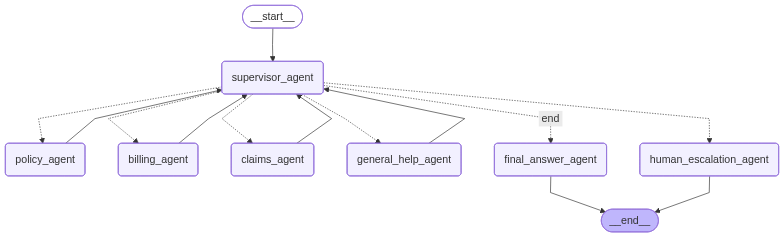

In [ ]:
def supervisor_agent(state):
    print("---SUPERVISOR AGENT---")
    logger.info("🔄 Supervisor agent started")
    
    # Check if we're coming from a clarification
    if state.get("needs_clarification", False):
        user_clarification = state.get("user_clarification", "")
        print(f"🔄 Processing user clarification: {user_clarification}")
        logger.info(f"🔄 Processing user clarification: {user_clarification}")
        
        # Update conversation history with the clarification exchange
        clarification_question = state.get("clarification_question", "")
        updated_conversation = state.get("conversation_history", "") + f"\nAssistant: {clarification_question}\nUser: {user_clarification}"
        
        # Update state to clear clarification flags and update history
        updated_state = state.copy()
        updated_state["needs_clarification"] = False
        updated_state["conversation_history"] = updated_conversation
        
        # Clear clarification fields
        if "clarification_question" in updated_state:
            del updated_state["clarification_question"]
        if "user_clarification" in updated_state:
            del updated_state["user_clarification"]
            
        return updated_state

    user_query = state["user_input"]
    conversation_history = state.get("conversation_history", "")
    
    # Check if we already have a policy number (including from previous iterations)
    policy_number = state.get("policy_number")
    customer_id = state.get("customer_id")
    
    print(f"User Query: {user_query}")
    print(f"Conversation History: {conversation_history}")
    if policy_number:
        print(f"✅ Available policy number: {policy_number}")
    if customer_id:
        print(f"✅ Available customer ID: {customer_id}")
    
    logger.info(f"📥 User query: {user_query}")

    # Build context for supervisor decision - include full conversation
    context_info = ""
    if policy_number:
        context_info += f"\nAvailable Policy Number: {policy_number}"
    if customer_id:
        context_info += f"\nAvailable Customer ID: {customer_id}"
    
    # Include the ENTIRE conversation history in the prompt
    full_context = f"Full Conversation:\n{conversation_history}\n\nCurrent Query: {user_query}"
    
    prompt = SUPERVISOR_PROMPT.format(
        #user_query=user_query,
        conversation_history=full_context,  # Use full context instead of just history
        context_info=context_info,
        policy_number=policy_number or "Not provided",
        customer_id=customer_id or "Not provided"
    )

    tools = [
        {
            "type": "function",
            "function": {
                "name": "ask_user",
                "description": "Ask the user for clarification or additional information when their query is unclear or missing important details. ONLY use this if essential information like policy number or customer ID is missing.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "question": {
                            "type": "string",
                            "description": "The specific question to ask the user for clarification"
                        },
                        "missing_info": {
                            "type": "string", 
                            "description": "What specific information is missing or needs clarification"
                        }
                    },
                    "required": ["question", "missing_info"]
                }
            }
        }
    ]

    print("🤖 Calling LLM for supervisor decision...")
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "system", "content": prompt}],
        tools=tools,
        tool_choice="auto"
    )

    message = response.choices[0].message

    # Check if supervisor wants to ask user for clarification
    if getattr(message, "tool_calls", None):
        print("🛠️ Supervisor requesting user clarification")
        for tool_call in message.tool_calls:
            if tool_call.function.name == "ask_user":
                args = json.loads(tool_call.function.arguments)
                question = args.get("question", "Can you please provide more details?")
                missing_info = args.get("missing_info", "additional information")
                
                print(f"❓ Asking user: {question}")
                logger.info(f"❓ Asking user for clarification: {question}")
                
                user_response_data = ask_user(question, missing_info)
                user_response = user_response_data["context"]
                
                print(f"✅ User response: {user_response}")
                logger.info(f"✅ User provided: {user_response}")
                
                # Update conversation history with the question
                updated_history = conversation_history + f"\nAssistant: {question}"
                updated_history = updated_history + f"\nUser: {user_response}"
                
                return {
                    "needs_clarification": True,
                    "clarification_question": question,
                    "user_clarification": user_response,
                    "conversation_history": updated_history
                }

    # If no tool calls, proceed with normal supervisor decision
    message_content = message.content
    
    try:
        parsed = json.loads(message_content)
        print("✅ Supervisor output parsed successfully")
    except json.JSONDecodeError:
        print("❌ Supervisor output invalid JSON, using fallback")
        parsed = {}

    next_agent = parsed.get("next_agent", "general_help_agent")
    task = parsed.get("task", "Assist the user with their query.")
    justification = parsed.get("justification", "")

    print(f"---SUPERVISOR DECISION: {next_agent}---")
    print(f"Task: {task}")
    print(f"Reason: {justification}")
    logger.info(f"🎯 Supervisor Decision → {next_agent}")

    # Update conversation history with the current exchange
    updated_conversation = conversation_history + f"\nUser: {user_query}\nAssistant: Routing to {next_agent} for: {task}"

    # if next_agent == "end":
    #     return {
    #         "next_agent": "final_answer_agent",
    #         "task": "Generate a clean final summary of the response",
    #         "justification": "Conversation complete - generating final summary for user",
    #         "conversation_history": updated_conversation
    #     }

    print(f"➡️ Routing to: {next_agent}")
    return {
        "next_agent": next_agent,
        "task": task,
        "justification": justification,
        "conversation_history": updated_conversation
    }

def claims_agent_node(state):
    logger.info("🏥 Claims agent started")
    logger.debug(f"Claims agent state: { {k: v for k, v in state.items() if k != 'messages'} }")
    
    prompt = CLAIMS_AGENT_PROMPT.format(
        task=state.get("task"),
        #user_query=state.get("user_input"),
        policy_number=state.get("policy_number", "Not provided"),
        claim_id=state.get("claim_id", "Not provided"),
        conversation_history=state.get("conversation_history", "")
    )

    tools = [
        {"type": "function", "function": {
            "name": "get_claim_status",
            "description": "Retrieve claim details",
            "parameters": {"type": "object", "properties": {"claim_id": {"type": "string"}, "policy_number": {"type": "string"}}}
        }}
    ]

    result = run_llm_with_tools(prompt, tools, {"get_claim_status": get_claim_status})
    
    logger.info("✅ Claims agent completed")
    return {"messages": [("assistant", result)]}

def final_answer_agent(state):
    """Generate a clean final summary before ending the conversation"""
    print("---FINAL ANSWER AGENT---")
    logger.info("🎯 Final answer agent started")
    
    user_query = state["user_input"]
    conversation_history = state.get("conversation_history", "")
    
    # Extract the most recent specialist response
    recent_responses = []
    for msg in reversed(state.get("messages", [])):
        if hasattr(msg, 'content') and "clarification" not in msg.content.lower():
            recent_responses.append(msg.content)
            if len(recent_responses) >= 2:  # Get last 2 non-clarification responses
                break
    
    specialist_response = recent_responses[0] if recent_responses else "No response available"
    
    prompt = FINAL_ANSWER_PROMPT.format(
        #user_query=user_query,
        specialist_response=specialist_response,  
        user_query=user_query,
    )
    
    print("🤖 Generating final summary...")
    response = client.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role": "system", "content": prompt}]
    )
    
    final_answer = response.choices[0].message.content
    
    print(f"✅ Final answer: {final_answer}")
    logger.info("✅ Final answer generated")
    
    # Replace all previous messages with just the final answer
    clean_messages = [("assistant", final_answer)]
    
    return {
        "messages": clean_messages,
        "final_answer": final_answer,
        "end_conversation": True,
        "conversation_history": conversation_history + f"\nAssistant: {final_answer}"
    }


def run_llm_with_tools(prompt: str, tools: List[Dict], tool_functions: Dict[str, Any]):
    print(f"🤖 Calling LLM with {len(tools)} tools...")
    logger.info(f"🤖 Calling LLM with {len(tools)} tools available")
    logger.debug(f"Tools: {[tool['function']['name'] for tool in tools]}")
    
    response = client.chat.completions.create(
        model="gpt-5-mini",  # Changed from gpt-5-mini to actual model
        messages=[{"role": "system", "content": prompt}],
        tools=tools,
        tool_choice="auto"
    )

    message = response.choices[0].message
    if not getattr(message, "tool_calls", None):
        print("📝 LLM returned direct response")
        logger.info("📝 LLM returned direct response (no tool calls)")
        return message.content

    print(f"🛠️ LLM calling {len(message.tool_calls)} tool(s)")
    logger.info(f"🛠️ LLM is calling {len(message.tool_calls)} tool(s)")
    
    # Collect all tool responses
    tool_responses = []
    for tool_call in message.tool_calls:
        func_name = tool_call.function.name
        args = json.loads(tool_call.function.arguments)
        print(f"🔧 Tool call: {func_name}")
        logger.info(f"🔧 Tool call: {func_name} with args: {args}")
        
        tool_fn = tool_functions.get(func_name)
        if tool_fn:
            print(f"⚡ Executing: {func_name}")
            logger.info(f"⚡ Executing tool: {func_name}")
            result = tool_fn(**args)
            logger.debug(f"Tool result: {result}")
            
            # Add tool response to the list
            tool_responses.append({
                "tool_call_id": tool_call.id,
                "role": "tool",
                "name": func_name,
                "content": json.dumps(result)
            })
        else:
            print(f"❌ Tool not found: {func_name}")
            logger.error(f"❌ Tool function not found: {func_name}")
            result = {"error": f"Tool {func_name} not available"}
            tool_responses.append({
                "tool_call_id": tool_call.id,
                "role": "tool", 
                "name": func_name,
                "content": json.dumps(result)
            })

    print("🔄 Getting final response from LLM with tool results...")
    
    # Build the messages for the final LLM call
    final_messages = [
        {"role": "system", "content": prompt},
        {
            "role": "assistant",
            "content": message.content,
            "tool_calls": [
                {
                    "id": tool_call.id,
                    "type": "function",
                    "function": {
                        "name": tool_call.function.name,
                        "arguments": tool_call.function.arguments
                    }
                }
                for tool_call in message.tool_calls
            ]
        }
    ]
    
    # Add all tool responses
    final_messages.extend(tool_responses)
    
    final_response = client.chat.completions.create(
        model="gpt-5-mini",
        messages=final_messages
    )
    
    print("✅ Tool execution completed")
    logger.info("✅ Tool execution completed, returning final response")
    return final_response.choices[0].message.content
    

def policy_agent_node(state):
    print("---POLICY AGENT---")
    logger.info("📄 Policy agent started")
    logger.debug(f"Policy agent state: { {k: v for k, v in state.items() if k != 'messages'} }")
    
    prompt = POLICY_AGENT_PROMPT.format(
        task=state.get("task"),
        #user_query=state.get("user_input"),
        policy_number=state.get("policy_number", "Not provided"),
        customer_id=state.get("customer_id", "Not provided"),
        conversation_history=state.get("conversation_history", "")
    )

    tools = [
        {"type": "function", "function": {
            "name": "get_policy_details",
            "description": "Fetch policy info by policy number",
            "parameters": {"type": "object", "properties": {"policy_number": {"type": "string"}}}
        }},
        {"type": "function", "function": {
            "name": "get_auto_policy_details",
            "description": "Get auto policy details",
            "parameters": {"type": "object", "properties": {"policy_number": {"type": "string"}}}
        }}
    ]

    print("🔄 Processing policy request...")
    result = run_llm_with_tools(prompt, tools, {
        "get_policy_details": get_policy_details,
        "get_auto_policy_details": get_auto_policy_details
    })
    
    print("✅ Policy agent completed")
    logger.info("✅ Policy agent completed")
    return {"messages": [("assistant", result)]}


def billing_agent_node(state):
    print("---BILLING AGENT---")
    logger.info("💰 Billing agent started")
    print("TASK: ", state.get("task"))
    print("USER QUERY: ", state.get("user_input"))
    print("CONVERSATION HISTORY: ", state.get("conversation_history", ""))
    
    
    prompt = BILLING_AGENT_PROMPT.format(
        task=state.get("task"),
        #user_query=state.get("user_input"),
        #policy_number=state.get("policy_number", "Not provided"),
        #customer_id=state.get("customer_id", "Not provided"),
        conversation_history=state.get("conversation_history", "")
    )

    tools = [
        {"type": "function", "function": {
            "name": "get_billing_info",
            "description": "Retrieve billing information",
            "parameters": {"type": "object", "properties": {"policy_number": {"type": "string"}, "customer_id": {"type": "string"}}}
        }},
        {"type": "function", "function": {
            "name": "get_payment_history",
            "description": "Fetch recent payment history",
            "parameters": {"type": "object", "properties": {"policy_number": {"type": "string"}}}
        }}
    ]

    print("🔄 Processing billing request...")
    result = run_llm_with_tools(prompt, tools, {
        "get_billing_info": get_billing_info,
        "get_payment_history": get_payment_history
    })
    
    print("✅ Billing agent completed")
    logger.info("✅ Billing agent completed")
    
    # Extract and preserve policy number if mentioned in the conversation
    updated_state = {"messages": [("assistant", result)]}
    
    # If we have a policy number in state, preserve it
    if state.get("policy_number"):
        updated_state["policy_number"] = state["policy_number"]
    if state.get("customer_id"):
        updated_state["customer_id"] = state["customer_id"]
        
    # Update conversation history
    current_history = state.get("conversation_history", "")
    updated_state["conversation_history"] = current_history + f"\nBilling Agent: {result}"
    
    return updated_state



def general_help_agent_node(state):
    print("---GENERAL HELP AGENT---")
    logger.info("ℹ️ General help agent started")
    logger.debug(f"General help state: { {k: v for k, v in state.items() if k != 'messages'} }")
    
    user_query = state.get("user_input", "")
    conversation_history = state.get("conversation_history", "")
    task = state.get("task", "General insurance support")

    # Step 1: Retrieve relevant FAQs from the vector DB
    print("🔍 Retrieving FAQs...")
    logger.info("🔍 Retrieving FAQs from vector database")
    results = collection.query(
        query_texts=[user_query],
        n_results=3,
        include=["metadatas", "documents", "distances"]
    )

    # Step 2: Format retrieved FAQs
    faq_context = ""
    if results and results.get("metadatas") and results["metadatas"][0]:
        print(f"📚 Found {len(results['metadatas'][0])} relevant FAQs")
        logger.info(f"📚 Found {len(results['metadatas'][0])} relevant FAQs")
        for i, meta in enumerate(results["metadatas"][0]):
            q = meta.get("question", "")
            a = meta.get("answer", "")
            score = results["distances"][0][i]
            faq_context += f"FAQ {i+1} (score: {score:.3f})\nQ: {q}\nA: {a}\n\n"
    else:
        print("❌ No relevant FAQs found")
        logger.info("❌ No relevant FAQs found")
        faq_context = "No relevant FAQs were found."

    # Step 3: Format the final prompt
    prompt = GENERAL_HELP_PROMPT.format(
        task=task,
        #user_query=user_query,
        conversation_history=conversation_history,
        faq_context=faq_context
    )

    print("🤖 Generating response...")
    logger.info("🤖 Calling LLM for general help response")
    final_answer = llm_without_tool(prompt)

    
    
    print("✅ General help agent completed")
    logger.info("✅ General help agent completed")
    updated_state = {
                        "messages": [("assistant", final_answer)],
                        "retrieved_faqs": results.get("metadatas", []),
                    }


    updated_state["conversation_history"] = conversation_history + f"\nGeneral Help Agent: {final_answer}"

    return updated_state


def human_escalation_node(state):
    print("---HUMAN ESCALATION AGENT---")
    logger.info("👨‍💼 Human escalation agent started")
    logger.warning(f"Escalation triggered - State: { {k: v for k, v in state.items() if k != 'messages'} }")
    
    prompt = HUMAN_ESCALATION_PROMPT.format(
        task=state.get("task"),
        #user_query=state.get("user_input"),
        conversation_history=state.get("conversation_history", "")
    )

    print("🤖 Generating escalation response...")
    response = client.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role": "system", "content": prompt}]
    )

    print("🚨 Conversation escalated to human")
    logger.info("🚨 Conversation escalated to human agent")
    return {
        "requires_human_escalation": True,
        "escalation_reason": "Customer requested human assistance.",
        "messages": [("assistant", response.choices[0].message.content)]
    }



from langgraph.graph import StateGraph, END


from typing import TypedDict, List, Annotated, Dict, Any, Optional
from langgraph.graph import add_messages
from datetime import datetime

class GraphState(TypedDict):
    # Core conversation tracking
    messages: Annotated[List[Any], add_messages]
    user_input: str
    conversation_history: Optional[str]

    # Extracted context & metadata
    user_intent: Optional[str]            # e.g., "query_policy", "billing_issue"
    customer_id: Optional[str]
    policy_number: Optional[str]
    claim_id: Optional[str]
    
    # Supervisor / routing layer
    next_agent: Optional[str]             # e.g., "policy_agent", "claims_agent", etc.
    task: Optional[str]                   # Current task determined by supervisor
    justification: Optional[str]          # Supervisor reasoning/explanation
    end_conversation: Optional[bool]      # Flag for graceful conversation termination
    
    # Entity extraction and DB lookups
    extracted_entities: Dict[str, Any]    # Parsed from user input (dates, names, etc.)
    database_lookup_result: Dict[str, Any]
    
    # Escalation state
    requires_human_escalation: bool
    escalation_reason: Optional[str]
    
    # Billing-specific fields
    billing_amount: Optional[float]
    payment_method: Optional[str]
    billing_frequency: Optional[str]      # "monthly", "quarterly", "annual"
    invoice_date: Optional[str]
    
    # System-level metadata
    timestamp: Optional[str]              # Track time of latest user message or state update


def decide_next_agent(state):
    # Handle clarification case first
    if state.get("needs_clarification"):
        return "supervisor_agent"  # Return to supervisor to process the clarification
    
    if state.get("end_conversation"):
        return "end"
    
    if state.get("requires_human_escalation"):
        return "human_escalation_agent"
    
    return state.get("next_agent", "general_help_agent")

# Update the workflow to include the final_answer_agent
workflow = StateGraph(GraphState)

workflow.add_node("supervisor_agent", supervisor_agent)
workflow.add_node("policy_agent", policy_agent_node)
workflow.add_node("billing_agent", billing_agent_node)
workflow.add_node("claims_agent", claims_agent_node)
workflow.add_node("general_help_agent", general_help_agent_node)
workflow.add_node("human_escalation_agent", human_escalation_node)
workflow.add_node("final_answer_agent", final_answer_agent)  # Add this

workflow.set_entry_point("supervisor_agent")

def decide_next_agent(state):
    # Handle clarification case first
    if state.get("needs_clarification"):
        return "supervisor_agent"
    
    if state.get("end_conversation"):
        return "end"
    
    if state.get("requires_human_escalation"):
        return "human_escalation_agent"
    
    return state.get("next_agent", "general_help_agent")

workflow.add_conditional_edges(
    "supervisor_agent",
    decide_next_agent,
    {
        "policy_agent": "policy_agent",
        "billing_agent": "billing_agent", 
        "claims_agent": "claims_agent",
        "human_escalation_agent": "human_escalation_agent",
        "general_help_agent": "general_help_agent",
        #"final_answer_agent": "final_answer_agent",  # Add this
        "end": "final_answer_agent"
    }
)

# Return to Supervisor after each specialist
for node in ["policy_agent", "billing_agent", "claims_agent", "general_help_agent"]:
    workflow.add_edge(node, "supervisor_agent")

# Final answer agent → END
workflow.add_edge("final_answer_agent", END)

# Human escalation → END
workflow.add_edge("human_escalation_agent", END)

app = workflow.compile()


# === Display the Graph ===
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [78]:

def run_test_query(query):
    """Test the system with a billing query"""
    initial_state = {
        "messages": [],
        "user_input": query,
        "user_intent": "",
        "claim_id": "",
        "next_agent": "supervisor_agent",
        "extracted_entities": {},
        "database_lookup_result": {},
        "requires_human_escalation": False,
        "escalation_reason": "",
        "billing_amount": None,
        "payment_method": None,
        "billing_frequency": None,
        "invoice_date": None,
        "conversation_history": f"User: {query}", 
        "task": "Help user with their query"
    }
    
    print(f"\n{'='*50}")
    print(f"QUERY: {query}")
    print(f"\n{'='*50}")
    
    # Run the graph
    final_state = app.invoke(initial_state)
    
    # Print the response
    print("\n---FINAL RESPONSE---")
    assistant_messages = []
    
    # Extract all assistant messages from different message formats
    for message in final_state.get("messages", []):
        if isinstance(message, tuple) and message[0] == "assistant":
            assistant_messages.append(message[1])
            print(f"ASSISTANT: {message[1]}")
        elif isinstance(message, dict) and message.get("role") == "assistant":
            content = message.get('content', '')
            assistant_messages.append(content)
            print(f"ASSISTANT: {content}")
        elif hasattr(message, 'content'):  # Handle AIMessage objects
            assistant_messages.append(message.content)
            print(f"ASSISTANT: {message.content}")
        elif isinstance(message, str):
            assistant_messages.append(message)
            print(f"ASSISTANT: {message}")
    
    # If no assistant messages found, check conversation history
    if not assistant_messages:
        print("No assistant messages found in final state.")
        if "conversation_history" in final_state:
            print(f"CONVERSATION HISTORY: {final_state['conversation_history']}")
    
    return final_state

In [ ]:
test_query = "What is the premium of my auto insurance policy?"
final_output =     run_test_query(test_query)

2025-11-10 19:17:07,065 - __main__ - INFO - 🔄 Supervisor agent started
2025-11-10 19:17:07,066 - __main__ - INFO - 📥 User query: What is the premium of my auto insurance policy?



QUERY: What is the premium of my auto insurance policy?

---SUPERVISOR AGENT---
User Query: What is the premium of my auto insurance policy?
Conversation History: User: What is the premium of my auto insurance policy?
🤖 Calling LLM for supervisor decision...


2025-11-10 19:17:08,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 19:17:08,773 - __main__ - INFO - ❓ Asking user for clarification: Please provide your policy number.
2025-11-10 19:17:08,776 - __main__ - INFO - 🗣️ Asking user for input: Please provide your policy number.


🛠️ Supervisor requesting user clarification
❓ Asking user: Please provide your policy number.
---USER INPUT REQUIRED---
Missing information: policy number


2025-11-10 19:17:13,288 - __main__ - INFO - ✅ User provided response: POL000001
2025-11-10 19:17:13,289 - __main__ - INFO - ✅ User provided: POL000001
2025-11-10 19:17:13,293 - __main__ - INFO - 🔄 Supervisor agent started
2025-11-10 19:17:13,294 - __main__ - INFO - 📥 User query: What is the premium of my auto insurance policy?


✅ User response: POL000001
---SUPERVISOR AGENT---
User Query: What is the premium of my auto insurance policy?
Conversation History: User: What is the premium of my auto insurance policy?
Assistant: Please provide your policy number.
User: POL000001
🤖 Calling LLM for supervisor decision...


2025-11-10 19:17:14,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 19:17:14,916 - __main__ - INFO - 🎯 Supervisor Decision → billing_agent
2025-11-10 19:17:14,918 - __main__ - INFO - 💰 Billing agent started
2025-11-10 19:17:14,919 - __main__ - INFO - 🤖 Calling LLM with 2 tools available


✅ Supervisor output parsed successfully
---SUPERVISOR DECISION: billing_agent---
Task: Check the premium for auto insurance policy POL000001.
Reason: The user provided the policy number and is inquiring about the premium, which is a billing question.
➡️ Routing to: billing_agent
---BILLING AGENT---
TASK:  Check the premium for auto insurance policy POL000001.
USER QUERY:  What is the premium of my auto insurance policy?
CONVERSATION HISTORY:  User: What is the premium of my auto insurance policy?
Assistant: Please provide your policy number.
User: POL000001
User: What is the premium of my auto insurance policy?
Assistant: Routing to billing_agent for: Check the premium for auto insurance policy POL000001.
🔄 Processing billing request...
🤖 Calling LLM with 2 tools...


2025-11-10 19:17:19,656 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 19:17:19,667 - __main__ - INFO - 🛠️ LLM is calling 2 tool(s)
2025-11-10 19:17:19,668 - __main__ - INFO - 🔧 Tool call: get_billing_info with args: {'policy_number': 'POL000001'}
2025-11-10 19:17:19,668 - __main__ - INFO - ⚡ Executing tool: get_billing_info
2025-11-10 19:17:19,669 - __main__ - INFO - 🔍 Fetching billing info - Policy: POL000001, Customer: None
2025-11-10 19:17:19,673 - __main__ - INFO - ✅ Billing info found
2025-11-10 19:17:19,674 - __main__ - INFO - 🔧 Tool call: get_payment_history with args: {'policy_number': 'POL000001'}
2025-11-10 19:17:19,674 - __main__ - INFO - ⚡ Executing tool: get_payment_history
2025-11-10 19:17:19,674 - __main__ - INFO - 🔍 Fetching payment history for policy: POL000001
2025-11-10 19:17:19,681 - __main__ - INFO - ✅ Found 5 payment records


🛠️ LLM calling 2 tool(s)
🔧 Tool call: get_billing_info
⚡ Executing: get_billing_info
🔧 Tool call: get_payment_history
⚡ Executing: get_payment_history
🔄 Getting final response from LLM with tool results...


2025-11-10 19:17:26,735 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 19:17:26,740 - __main__ - INFO - ✅ Tool execution completed, returning final response
2025-11-10 19:17:26,742 - __main__ - INFO - ✅ Billing agent completed
2025-11-10 19:17:26,748 - __main__ - INFO - 🔄 Supervisor agent started
2025-11-10 19:17:26,749 - __main__ - INFO - 📥 User query: What is the premium of my auto insurance policy?


✅ Tool execution completed
✅ Billing agent completed
---SUPERVISOR AGENT---
User Query: What is the premium of my auto insurance policy?
Conversation History: User: What is the premium of my auto insurance policy?
Assistant: Please provide your policy number.
User: POL000001
User: What is the premium of my auto insurance policy?
Assistant: Routing to billing_agent for: Check the premium for auto insurance policy POL000001.
Billing Agent: The premium for policy POL000001 is $202.11 per quarter.
🤖 Calling LLM for supervisor decision...


2025-11-10 19:17:29,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 19:17:29,489 - __main__ - INFO - 🎯 Supervisor Decision → end
2025-11-10 19:17:29,491 - __main__ - INFO - 🎯 Final answer agent started


✅ Supervisor output parsed successfully
---SUPERVISOR DECISION: end---
Task: The premium for policy POL000001 is $202.11 per quarter.
Reason: The premium information has already been provided by the billing agent.
---FINAL ANSWER AGENT---
🤖 Generating final summary...


2025-11-10 19:17:36,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 19:17:36,664 - __main__ - INFO - ✅ Final answer generated


✅ Final answer: Your auto insurance premium is $202.11 per quarter. Thank you.

---FINAL RESPONSE---
ASSISTANT: The premium for policy POL000001 is $202.11 per quarter.
ASSISTANT: Your auto insurance premium is $202.11 per quarter. Thank you.


In [79]:
test_query = "In general, what does life insurance cover? Route this to the general help agent."
final_output =     run_test_query(test_query)

2025-11-10 19:36:05,839 - __main__ - INFO - 🔄 Supervisor agent started
2025-11-10 19:36:05,841 - __main__ - INFO - 📥 User query: In general, what does life insurance cover? Route this to the general help agent.



QUERY: In general, what does life insurance cover? Route this to the general help agent.

---SUPERVISOR AGENT---
User Query: In general, what does life insurance cover? Route this to the general help agent.
Conversation History: User: In general, what does life insurance cover? Route this to the general help agent.
🤖 Calling LLM for supervisor decision...


2025-11-10 19:36:07,802 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 19:36:07,806 - __main__ - INFO - 🎯 Supervisor Decision → general_help_agent
2025-11-10 19:36:07,808 - __main__ - INFO - ℹ️ General help agent started
2025-11-10 19:36:07,809 - __main__ - INFO - 🔍 Retrieving FAQs from vector database


✅ Supervisor output parsed successfully
---SUPERVISOR DECISION: general_help_agent---
Task: User inquired about what life insurance covers.
Reason: The user asked a general question about life insurance coverage.
➡️ Routing to: general_help_agent
---GENERAL HELP AGENT---
🔍 Retrieving FAQs...


2025-11-10 19:36:08,017 - __main__ - INFO - 📚 Found 3 relevant FAQs
2025-11-10 19:36:08,018 - __main__ - INFO - 🤖 Calling LLM for general help response


📚 Found 3 relevant FAQs
🤖 Generating response...


2025-11-10 19:36:16,265 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 19:36:16,271 - __main__ - INFO - ✅ General help agent completed
2025-11-10 19:36:16,273 - __main__ - INFO - 🔄 Supervisor agent started
2025-11-10 19:36:16,274 - __main__ - INFO - 📥 User query: In general, what does life insurance cover? Route this to the general help agent.


✅ General help agent completed
---SUPERVISOR AGENT---
User Query: In general, what does life insurance cover? Route this to the general help agent.
Conversation History: User: In general, what does life insurance cover? Route this to the general help agent.
User: In general, what does life insurance cover? Route this to the general help agent.
Assistant: Routing to general_help_agent for: User inquired about what life insurance covers.
General Help Agent: In general, life insurance pays a death benefit to the person(s) you name (the beneficiaries) if the insured person dies while the policy is in force.

Typical points to know:
- What it pays for: the payout is intended to help your family or other beneficiaries with things like paying off debt, covering living expenses or college costs, and paying funeral or other final expenses.
- What causes of death are covered: most policies cover death from illness, injury, or “old age.” Many policies also pay after the policy has been in force f

2025-11-10 19:36:18,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 19:36:18,130 - __main__ - INFO - 🎯 Supervisor Decision → general_help_agent
2025-11-10 19:36:18,132 - __main__ - INFO - ℹ️ General help agent started
2025-11-10 19:36:18,139 - __main__ - INFO - 🔍 Retrieving FAQs from vector database


✅ Supervisor output parsed successfully
---SUPERVISOR DECISION: general_help_agent---
Task: User inquired about what life insurance covers.
Reason: User's query is a general question about life insurance coverage.
➡️ Routing to: general_help_agent
---GENERAL HELP AGENT---
🔍 Retrieving FAQs...


2025-11-10 19:36:18,590 - __main__ - INFO - 📚 Found 3 relevant FAQs
2025-11-10 19:36:18,590 - __main__ - INFO - 🤖 Calling LLM for general help response


📚 Found 3 relevant FAQs
🤖 Generating response...


2025-11-10 19:36:28,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 19:36:28,323 - __main__ - INFO - ✅ General help agent completed
2025-11-10 19:36:28,328 - __main__ - INFO - 🔄 Supervisor agent started
2025-11-10 19:36:28,329 - __main__ - INFO - 📥 User query: In general, what does life insurance cover? Route this to the general help agent.


✅ General help agent completed
---SUPERVISOR AGENT---
User Query: In general, what does life insurance cover? Route this to the general help agent.
Conversation History: User: In general, what does life insurance cover? Route this to the general help agent.
User: In general, what does life insurance cover? Route this to the general help agent.
Assistant: Routing to general_help_agent for: User inquired about what life insurance covers.
General Help Agent: In general, life insurance pays a death benefit to the person(s) you name (the beneficiaries) if the insured person dies while the policy is in force.

Typical points to know:
- What it pays for: the payout is intended to help your family or other beneficiaries with things like paying off debt, covering living expenses or college costs, and paying funeral or other final expenses.
- What causes of death are covered: most policies cover death from illness, injury, or “old age.” Many policies also pay after the policy has been in force f

2025-11-10 19:36:30,020 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-10 19:36:30,026 - __main__ - INFO - 🎯 Supervisor Decision → general_help_agent
2025-11-10 19:36:30,028 - __main__ - INFO - ℹ️ General help agent started
2025-11-10 19:36:30,029 - __main__ - INFO - 🔍 Retrieving FAQs from vector database


✅ Supervisor output parsed successfully
---SUPERVISOR DECISION: general_help_agent---
Task: User inquired again about what life insurance covers.
Reason: User is repeatedly asking about the coverage details of life insurance.
➡️ Routing to: general_help_agent
---GENERAL HELP AGENT---
🔍 Retrieving FAQs...


2025-11-10 19:36:30,242 - __main__ - INFO - 📚 Found 3 relevant FAQs
2025-11-10 19:36:30,243 - __main__ - INFO - 🤖 Calling LLM for general help response


📚 Found 3 relevant FAQs
🤖 Generating response...


KeyboardInterrupt: 

In [73]:
final_output

{'messages': [AIMessage(content='The premium for policy POL000001 is $202.11 per quarter.', additional_kwargs={}, response_metadata={}, id='a0240514-d51c-4652-a26a-c62509b11b2e'),
  AIMessage(content='Your auto insurance premium is $202.11 per quarter. Thank you.', additional_kwargs={}, response_metadata={}, id='d4346144-d4f8-4862-9e3f-b957e3dba6e2')],
 'user_input': 'What is the premium of my auto insurance policy?',
 'conversation_history': 'User: What is the premium of my auto insurance policy?\nAssistant: Please provide your policy number.\nUser: POL000001\nUser: What is the premium of my auto insurance policy?\nAssistant: Routing to billing_agent for: Check the premium for auto insurance policy POL000001.\nBilling Agent: The premium for policy POL000001 is $202.11 per quarter.\nUser: What is the premium of my auto insurance policy?\nAssistant: Routing to end for: The premium for policy POL000001 is $202.11 per quarter.\nAssistant: Your auto insurance premium is $202.11 per quarter